# Step 1 : Imprort Required Libraries,Load merged Data and Load Optimized Weights

In [1]:
# Portfolio Backtesting (Task 5)

# Strategy Simulation and Performance Analysis
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent  # Adjust if notebook is deeper
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.backtesting import backtest_strategy, plot_backtest_results, generate_report
from src.data_processing import load_merged_data

# Load data
prices = load_merged_data()[['TSLA', 'SPY', 'BND']]
returns = prices.pct_change().dropna()
print("✅ Data Loaded Successfully")

✅ Data Loaded Successfully


In [2]:
# 1. Load Optimized Weights

# Load weights from Task 4
weights = pd.read_csv('../outputs/portfolios/optimal_weights.csv', index_col=0)
print("Optimized Weights:")
display(weights)

# Convert to dictionary format (can also use DataFrame with dates)
weights_dict = {
    'TSLA': weights['Max Sharpe'][0],
    'SPY': weights['Max Sharpe'][1],
    'BND': weights['Max Sharpe'][2]
}

Optimized Weights:


,Min Volatility,Max Sharpe
TSLA,0.000000,0.0
SPY,0.056062,0.0
BND,0.943938,1.0


C:\Users\dell\AppData\Local\Temp\ipykernel_19892\1511107731.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'TSLA': weights['Max Sharpe'][0],
C:\Users\dell\AppData\Local\Temp\ipykernel_19892\1511107731.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'SPY': weights['Max Sharpe'][1],
C:\Users\dell\AppData\Local\Temp\ipykernel_19892\1511107731.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'BND': weights['Max Sharpe'][2

# Step 2 : Run backtest with proper weight formatting

In [11]:
# 2. Run backtest with proper weight formatting
try:
    # Convert weights dictionary to properly shaped DataFrame
    weights_df = pd.DataFrame(
        np.tile(list(weights_dict.values()), (len(returns), 1)),
        index=returns.index,
        columns=returns.columns
    )
    
    results = backtest_strategy(
        returns=returns,
        weights=weights_df,  # Now passing DataFrame instead of dict
        rebalance_freq='QE',
        initial_capital=10000
    )
    
    # Display metrics with improved formatting
    print("\n" + "="*50)
    print("PORTFOLIO PERFORMANCE METRICS".center(50))
    print("="*50)
    
    metrics_data = {
        'CAGR': f"{results['metrics']['CAGR']:.2%}",
        'Annual Volatility': f"{results['metrics']['Volatility']:.2%}",
        'Sharpe Ratio': f"{results['metrics']['Sharpe Ratio']:.2f}",
        'Max Drawdown': f"{results['metrics']['Max Drawdown']:.2%}",
        'Sortino Ratio': f"{results['metrics']['Sortino Ratio']:.2f}" if results['metrics']['Sortino Ratio'] else "N/A"
    }
    
    metrics_df = pd.DataFrame.from_dict(
        metrics_data,
        orient='index',
        columns=['Value']
    ).rename_axis('Metric')
    
    # Styled display
    def color_negative_red(val):
        color = 'red' if '-' in val else 'black'
        return f'color: {color}'
    
    display(metrics_df.style
           .applymap(color_negative_red)
           .format(precision=2)
           .set_properties(**{'text-align': 'right'})
           .set_table_styles([{
               'selector': 'th',
               'props': [('text-align', 'left')]
           }]))
    
    print(f"\nRebalancing Events: {len(results['metrics']['Rebalance Dates'])}")  # Fixed missing parenthesis
    
except Exception as e:
    print(f"\nError in backtesting: {str(e)}")
    print("\nDebug Info:")
    print(f"Returns shape: {returns.shape}")
    print(f"Returns columns: {returns.columns.tolist()}")
    print(f"Weights dict: {weights_dict}")


          PORTFOLIO PERFORMANCE METRICS           


C:\Users\dell\AppData\Local\Temp\ipykernel_19892\3556396168.py:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_red)


,Value
Metric,
CAGR,0.94%
Annual Volatility,5.56%
Sharpe Ratio,-0.16
Max Drawdown,-13.40%
Sortino Ratio,-0.28



Rebalancing Events: 41


# Step 3 : Visualize Results

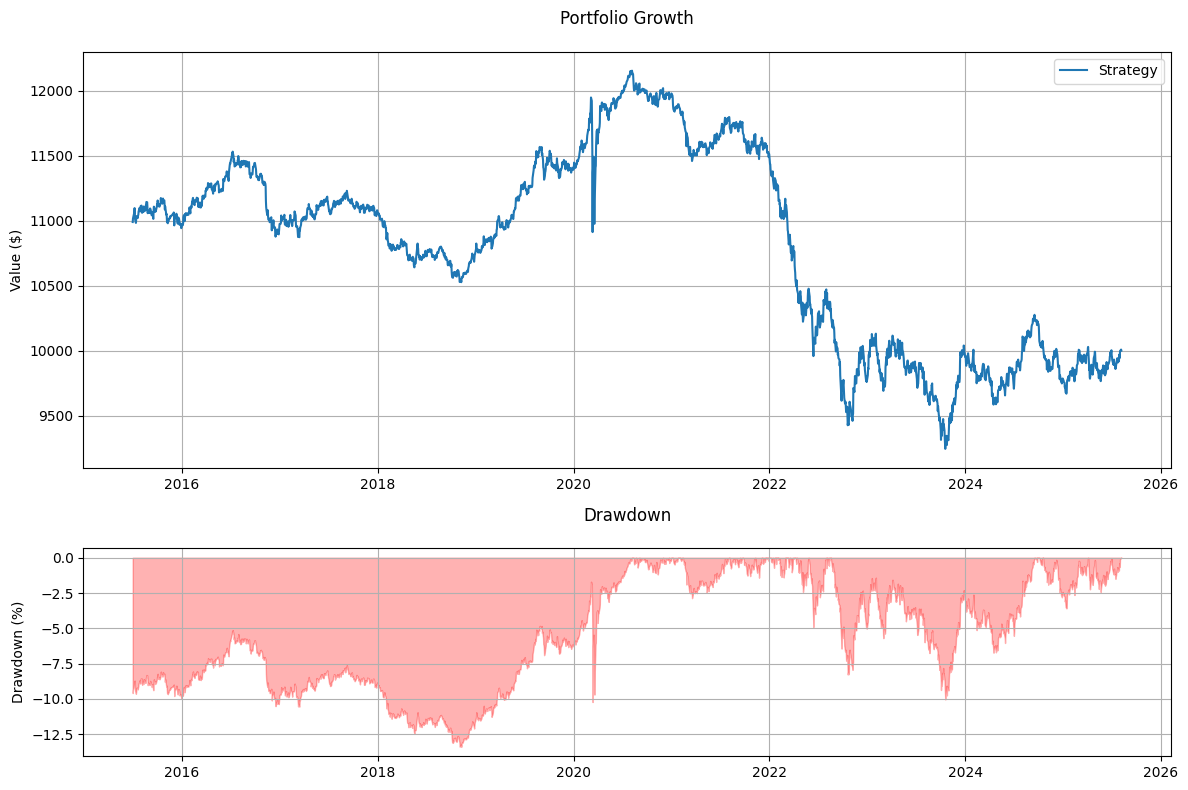

In [12]:
# 3. Visualize Results

# Plot performance
fig = plot_backtest_results(results)
plt.savefig('../outputs/visualizations/backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save full results
results['performance'].to_csv('../outputs/portfolios/backtest_performance.csv')
metrics_df.to_csv('../outputs/portfolios/backtest_metrics.csv')


# Step 4 : Compare with Benchmark

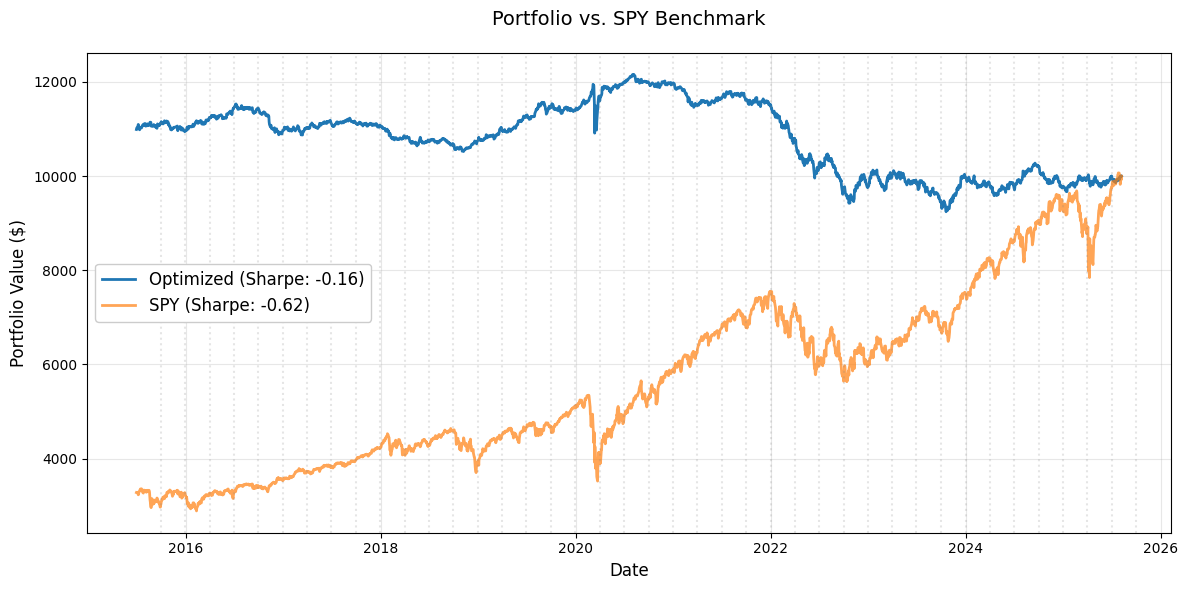


Performance Comparison:


,Optimized,SPY
Metric,,
CAGR,0.94%,-10.47%
Volatility,5.56%,18.42%
Sharpe Ratio,-0.16,-0.62
Max Drawdown,-13.40%,-71.30%


In [18]:
# 4. Compare with Benchmark

# Define parameters
initial_capital = 10000
rebalance_freq = 'QE'  # Quarter-end rebalancing

# Get SPY returns (ensure it's a DataFrame with one column)
spy_returns = returns[['SPY']].copy()

# Create proper weights DataFrame for benchmark
spy_weights = pd.DataFrame(
    np.ones(len(spy_returns)),
    index=spy_returns.index,
    columns=['SPY']
)

# Run benchmark backtest
benchmark_results = backtest_strategy(
    returns=spy_returns,
    weights=spy_weights,
    rebalance_freq=rebalance_freq,
    initial_capital=initial_capital
)

# Create comparison plot
plt.figure(figsize=(12, 6))

# Plot optimized portfolio
plt.plot(
    results['performance']['Portfolio Value'], 
    label=f'Optimized (Sharpe: {results["metrics"]["Sharpe Ratio"]:.2f})',
    linewidth=2
)

# Plot benchmark
plt.plot(
    benchmark_results['performance']['Portfolio Value'], 
    label=f'SPY (Sharpe: {benchmark_results["metrics"]["Sharpe Ratio"]:.2f})',
    alpha=0.7,
    linewidth=2
)

# Formatting
plt.title('Portfolio vs. SPY Benchmark', fontsize=14, pad=20)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12, framealpha=1)
plt.grid(True, alpha=0.3)

# Highlight rebalancing dates
for date in results['metrics']['Rebalance Dates']:
    plt.axvline(x=date, color='gray', linestyle=':', alpha=0.2)

plt.tight_layout()
plt.savefig('../outputs/visualizations/benchmark_comparison.png', 
           dpi=300, 
           bbox_inches='tight',
           transparent=False)
plt.show()

# Create comparison table
comparison_data = {
    'Metric': ['CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'],
    'Optimized': [
        f"{results['metrics']['CAGR']:.2%}",
        f"{results['metrics']['Volatility']:.2%}",
        f"{results['metrics']['Sharpe Ratio']:.2f}",
        f"{results['metrics']['Max Drawdown']:.2%}"
    ],
    'SPY': [
        f"{benchmark_results['metrics']['CAGR']:.2%}",
        f"{benchmark_results['metrics']['Volatility']:.2%}",
        f"{benchmark_results['metrics']['Sharpe Ratio']:.2f}",
        f"{benchmark_results['metrics']['Max Drawdown']:.2%}"
    ]
}

comparison_df = pd.DataFrame(comparison_data).set_index('Metric')
print("\nPerformance Comparison:")
display(comparison_df.style
       .set_properties(**{'text-align': 'center'})
       .set_table_styles([{
           'selector': 'th',
           'props': [('text-align', 'left')]
       }]))